<a href="https://colab.research.google.com/github/ashishkej/eva8_session2.5/blob/main/EVA8_Session_2_5_Pytorch_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms

In [2]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
dataset1 = torchvision.datasets.MNIST('./data', train=True, download=True,
                       transform=transform)
dataset2 = torchvision.datasets.MNIST('./data', train=False,
                       transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
train_kwargs = {'batch_size': 32}
test_kwargs = {'batch_size': 32}
cuda_kwargs = {       'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)


train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth=120)

In [5]:
len(dataset1), len(dataset2)

(60000, 10000)

In [6]:
dataset1.targets, dataset2.targets

(tensor([5, 0, 4,  ..., 5, 6, 8]), tensor([7, 2, 1,  ..., 4, 5, 6]))

In [7]:
dataset1.targets.bincount(), dataset1.targets.bincount()

(tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]),
 tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

label: 5


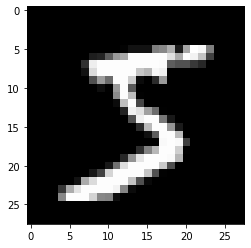

In [8]:
sample = next(iter(dataset1))
image, label = sample
plt.imshow(image.squeeze(), cmap='gray')
print('label:', label)

In [9]:
batch = next(iter(train_loader))

len(batch), type(batch)

(2, list)

In [10]:
images, labels = batch
images.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

labels: tensor([0, 8, 2, 3, 2, 3, 7, 9, 3, 1, 6, 3, 2, 3, 3, 4, 3, 3, 1, 5, 5, 6, 8, 5, 1, 9, 5, 2, 9, 7, 3, 1])


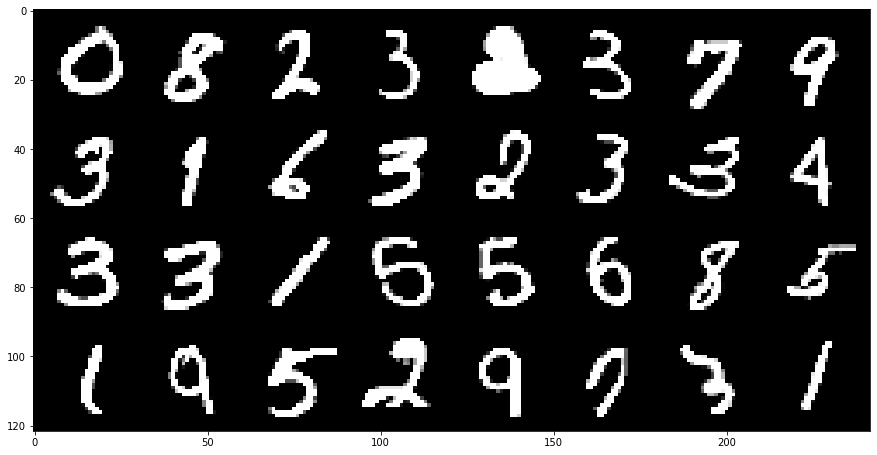

In [11]:
grid = torchvision.utils.make_grid(images, nrow=8)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', labels)

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = x.reshape(-1,64*12*12)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [55]:

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.fc3 = nn.Linear(in_features=20, out_features=10)
    self.out = nn.Linear(in_features=60, out_features=10)
  
  def forward(self, image, num):
    # input layer
    x = image

    # conv1 layer
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 28 | 24 | 12

    # conv2 layer
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 12 | 8 | 4 >> 12x4x4

    # reshapre
    x = x.reshape(-1, 12 * 4 * 4)

    # fc1 layer
    x = self.fc1(x)
    x = F.relu(x)

    # fc2 layer
    x = self.fc2(x)
    x = F.relu(x)

    # output layer
    x = self.out(x)
    output_mnist = F.softmax(x, dim=1)
    num = F.one_hot(num, num_classes=10)
    x = torch.cat((x, num), 1)
    x = self.fc3(x)
    output_sum = F.softmax(x, dim=1)
    return output_mnist, output_sum 

In [56]:
torch.set_grad_enabled(False)
image.shape, image.unsqueeze(0).shape

(torch.Size([1, 28, 28]), torch.Size([1, 1, 28, 28]))

In [83]:
network = Net()
for name, param in network.named_parameters():
  print(name, '\t\t', param.shape)

conv1.weight 		 torch.Size([6, 1, 5, 5])
conv1.bias 		 torch.Size([6])
conv2.weight 		 torch.Size([12, 6, 5, 5])
conv2.bias 		 torch.Size([12])
fc1.weight 		 torch.Size([120, 192])
fc1.bias 		 torch.Size([120])
fc2.weight 		 torch.Size([60, 120])
fc2.bias 		 torch.Size([60])
fc3.weight 		 torch.Size([10, 20])
fc3.bias 		 torch.Size([10])
out.weight 		 torch.Size([10, 60])
out.bias 		 torch.Size([10])


In [65]:
torch.randint(10, (1,))

tensor([9])

In [69]:
pred, sum= network(image,torch.randint(10, (1,)))

In [70]:
pred, sum= network(image.unsqueeze(0),torch.randint(10, (1,)))

In [72]:
pred, pred.shape, label,sum

(tensor([[0.0892, 0.0945, 0.1179, 0.1172, 0.0926, 0.1132, 0.0945, 0.0921, 0.0976, 0.0912]]),
 torch.Size([1, 10]),
 5,
 tensor([[0.0754, 0.1000, 0.1124, 0.1137, 0.1310, 0.0695, 0.1261, 0.0625, 0.1158, 0.0936]]))

In [73]:
pred.argmax()

tensor(2)

In [74]:
pred.sum()

tensor(1.0000)

In [75]:
batch = next(iter(train_loader))
len(batch[0])

32

In [77]:
images, labels = batch
nums = torch.randint(10, (len(batch[0]),))
preds, sums = network(images,nums)
preds.shape, sums.shape

(torch.Size([32, 10]), torch.Size([32, 10]))

In [29]:
preds

tensor([[0.0856, 0.0985, 0.1129, 0.0945, 0.0902, 0.1060, 0.1090, 0.1031, 0.1139, 0.0865],
        [0.0845, 0.1011, 0.1099, 0.0940, 0.0908, 0.1074, 0.1095, 0.1042, 0.1106, 0.0881],
        [0.0864, 0.1009, 0.1104, 0.0971, 0.0898, 0.1045, 0.1093, 0.1011, 0.1110, 0.0895],
        [0.0847, 0.0990, 0.1127, 0.0949, 0.0905, 0.1070, 0.1104, 0.1018, 0.1107, 0.0882],
        [0.0850, 0.0992, 0.1091, 0.0936, 0.0897, 0.1053, 0.1109, 0.1035, 0.1151, 0.0886],
        [0.0860, 0.0990, 0.1101, 0.0969, 0.0907, 0.1033, 0.1084, 0.1033, 0.1137, 0.0884],
        [0.0856, 0.1008, 0.1096, 0.0939, 0.0911, 0.1060, 0.1120, 0.1042, 0.1119, 0.0849],
        [0.0829, 0.1007, 0.1082, 0.0928, 0.0913, 0.1066, 0.1063, 0.1068, 0.1142, 0.0903],
        [0.0837, 0.0984, 0.1103, 0.0963, 0.0913, 0.1022, 0.1097, 0.1048, 0.1170, 0.0862],
        [0.0848, 0.0990, 0.1095, 0.0968, 0.0906, 0.1046, 0.1086, 0.1050, 0.1156, 0.0855],
        [0.0835, 0.1008, 0.1116, 0.0948, 0.0915, 0.1064, 0.1072, 0.1043, 0.1107, 0.0891],
        [0

In [30]:
preds.argmax(dim=1),labels

(tensor([8, 8, 8, 2, 8, 8, 6, 8, 8, 8, 2, 2, 8, 8, 8, 8, 8, 2, 8, 8, 8, 2, 8, 2, 8, 8, 8, 2, 2, 6, 8, 8]),
 tensor([1, 1, 2, 1, 9, 2, 2, 5, 0, 2, 1, 1, 3, 8, 5, 8, 5, 5, 0, 0, 5, 2, 4, 9, 3, 4, 8, 5, 5, 8, 3, 9]))

In [31]:
preds.argmax(dim=1).eq(labels)

tensor([False, False, False, False, False, False, False, False, False, False, False, False, False,  True, False,  True,
        False, False, False, False, False,  True, False, False, False, False,  True, False, False, False, False, False])

In [32]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [33]:
get_num_correct(preds, labels)

4

In [80]:
import torch.optim as optim

torch.set_grad_enabled(True)

In [84]:
images, labels = batch
nums = torch.randint(10, (len(batch[0]),))
preds, sums = network(images,nums)
loss = F.cross_entropy(preds, labels)
loss.item()

2.302173614501953

In [85]:
print(network.conv1.weight.grad)

None


In [86]:
loss.backward()

In [87]:
print(network.conv1.weight.grad)

tensor([[[[ 4.6966e-04,  5.0421e-04,  3.8633e-04,  6.0354e-04,  6.7810e-04],
          [ 7.1133e-04,  4.1559e-04,  5.1988e-04,  8.3446e-04,  6.6685e-04],
          [ 9.2227e-04,  7.2508e-04,  6.5369e-04,  8.5705e-04,  7.3729e-04],
          [ 9.3965e-04,  8.5698e-04,  6.5752e-04,  7.4273e-04,  1.0290e-03],
          [ 7.2001e-04,  6.0797e-04,  6.6050e-04,  1.0089e-03,  1.1831e-03]]],


        [[[-3.9365e-04, -4.0138e-04,  1.0188e-04,  4.9142e-04,  5.6141e-04],
          [-7.9032e-04, -5.5807e-04, -6.1139e-05,  2.3377e-04,  4.7034e-04],
          [-9.9012e-04, -6.9407e-04, -3.3660e-04,  7.0648e-05, -1.5775e-04],
          [-1.0979e-03, -7.5461e-04, -3.9637e-04, -1.0694e-04, -1.7964e-04],
          [-7.2459e-04, -1.7603e-04, -1.3929e-04,  6.6701e-05,  3.0141e-04]]],


        [[[ 3.0495e-04,  1.2468e-04, -2.8598e-04, -1.3257e-04, -8.5728e-05],
          [-4.8474e-05, -2.7902e-04, -3.8520e-04, -4.8513e-04, -5.8735e-04],
          [-3.0468e-04, -5.0258e-04, -4.9104e-04, -5.2110e-04, -3.88

In [88]:
optimizer = optim.Adam(network.parameters(), lr = 0.01)
loss.item(), get_num_correct(preds, labels)

(2.302173614501953, 6)

In [89]:
optimizer.step()

In [90]:
nums = torch.randint(10, (len(batch[0]),))
preds, sums = network(images,nums)
loss = F.cross_entropy(preds, labels)
loss.item(), get_num_correct(preds, labels)

(2.2767224311828613, 11)

In [91]:
loss.backward()
optimizer.step()
nums = torch.randint(10, (len(batch[0]),))
preds, sums = network(images,nums)
loss = F.cross_entropy(preds, labels)
loss.item(), get_num_correct(preds, labels)

(2.231602668762207, 6)

In [92]:
loss.backward()
optimizer.step()
nums = torch.randint(10, (len(batch[0]),))
preds, sums = network(images,nums)
loss = F.cross_entropy(preds, labels)
loss.item(), get_num_correct(preds, labels)

(2.2388203144073486, 9)

In [93]:
loss.backward()
optimizer.step()
nums = torch.randint(10, (len(batch[0]),))
preds, sums = network(images,nums)
loss = F.cross_entropy(preds, labels)
loss.item(), get_num_correct(preds, labels)

(2.304892063140869, 5)

In [94]:
loss.backward()
optimizer.step()
nums = torch.randint(10, (len(batch[0]),))
preds, sums = network(images,nums)
loss = F.cross_entropy(preds, labels)
loss.item(), get_num_correct(preds, labels)

(2.304900646209717, 5)

In [47]:
loss.backward()
optimizer.step()
preds = network(images)
loss = F.cross_entropy(preds, labels)
loss.item(), get_num_correct(preds, labels)

(2.304900646209717, 5)

In [48]:
loss.backward()
optimizer.step()
preds = network(images)
loss = F.cross_entropy(preds, labels)
loss.item(), get_num_correct(preds, labels)

(2.304900646209717, 5)

In [49]:
loss.backward()
optimizer.step()
preds = network(images)
loss = F.cross_entropy(preds, labels)
loss.item(), get_num_correct(preds, labels)

(2.304900646209717, 5)

In [50]:
loss.backward()
optimizer.step()
preds = network(images)
loss = F.cross_entropy(preds, labels)
loss.item(), get_num_correct(preds, labels)

(2.304900646209717, 5)

In [96]:
network = Net()

optimizer = optim.Adam(network.parameters(), lr=0.01)

batch = next(iter(train_loader)) # Get Batch
images, labels = batch
nums = torch.randint(10, (len(batch[0]),))
preds, sums = network(images,nums)

loss = F.cross_entropy(preds, labels) # Calculate Loss

loss.backward() # Calculate Gradients
optimizer.step() # Update Weights

print('loss1:', loss.item())
preds, sums = network(images,nums)
loss = F.cross_entropy(preds, labels)
print('loss2:', loss.item())

loss1: 2.3039910793304443
loss2: 2.2953853607177734


In [97]:
torch.set_grad_enabled(True)


In [158]:
network = Net()

optimizer = optim.Adam(network.parameters(), lr=0.01)

total_loss = 0
total_correct = 0

for batch in train_loader: # Get Batch
    images, labels = batch 

    preds = network(images) # Pass Batch
    loss = F.cross_entropy(preds, labels) # Calculate Loss

    optimizer.zero_grad()
    loss.backward() # Calculate Gradients
    optimizer.step() # Update Weights

    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)

print(
    "epoch:", 0, 
    "total_correct:", total_correct, 
    "loss:", total_loss
)

epoch: 0 total_correct: 6531 loss: 4329.246712207794


In [98]:
device = torch.device("cuda")
network = Net().to(device)
optimizer = optim.Adam(network.parameters(), lr=0.01)

for epoch in range(10):
    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 
        nums = torch.randint(10, (len(batch[0]),), device=device)
        images, labels = images.to(device), labels.to(device)
        preds_mnist, preds_sum = network(images,nums) # Pass Batch
        loss1 = F.cross_entropy(preds_mnist, labels)  # Calculate Loss
        loss2 = F.cross_entropy(preds_sum, nums)

        loss = loss1 + 0.000001*loss2
        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds_mnist, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: 26805 loss: 3775.86141037941
epoch 1 total_correct: 11038 loss: 4269.701722145081
epoch 2 total_correct: 5842 loss: 4432.099867105484
epoch 3 total_correct: 5842 loss: 4432.099864244461
epoch 4 total_correct: 5842 loss: 4432.09986782074
epoch 5 total_correct: 5842 loss: 4432.099866867065
epoch 6 total_correct: 5842 loss: 4432.0998656749725
epoch 7 total_correct: 5842 loss: 4432.09986448288
epoch 8 total_correct: 5842 loss: 4432.0998611450195
epoch 9 total_correct: 5842 loss: 4432.099864244461
